# Exercice 1

In [110]:
X = [1,2,3,4]
p = [0.7,0.2,0.1,0.0]


In [111]:
import numpy as np
import time
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal

In [112]:
def loi(X,p) :
    P_ = np.cumsum(p)
    rand = np.random.rand()
    return( next((x for i,x in enumerate(X) if P_[i] >= rand )) )

In [113]:
print(loi(X,p))

1


In [114]:
X_count = [0,0,0,0]
for j in range(1000) :
    LOI = loi(X,p)
    X_count[LOI - 1] = X_count[LOI - 1] + 1


X_count = np.array(X_count)/1000

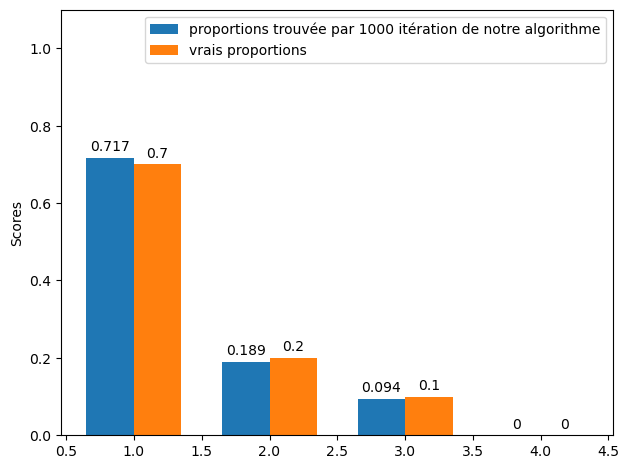

In [115]:
men_means = X_count
women_means = np.array(p)

x = np.array(X)
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, men_means, width, label='proportions trouvée par 1000 itération de notre algorithme')
rects2 = ax.bar(x + width/2, women_means, width, label='vrais proportions')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Scores')
ax.legend()

ax.bar_label(rects1, padding=3)
ax.bar_label(rects2, padding=3)

fig.tight_layout()

plt.ylim([0.0,1.1])
plt.show()


   # Exercice 2

##  2

In [116]:
alphas = np.array([0.1,0.4,0.3,0.2])
mus = np.array([[-5,-4],[2,-1],[-4,2],[1,1]])
sigmas = np.array([ [[1,0],[0,1]] , [[2,0],[0,1]] , [[3,2],[2,2]] , [[1,0],[0,1]] ] )

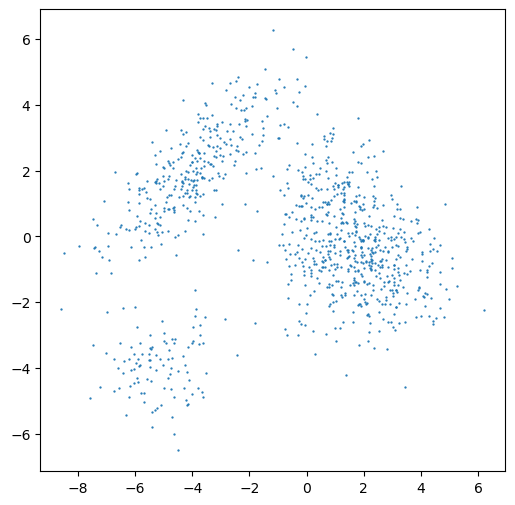

In [117]:
liste_points = []
for i in range(1000) :
    indice = loi([0,1,2,3],alphas)
    liste_points.append(np.random.multivariate_normal(mean = mus[indice], cov = sigmas[indice], tol=1e-8))

liste_points = np.array(liste_points)
X = liste_points.copy()

fig = plt.figure(figsize=(6,6))
ax0 = fig.add_subplot(111)
ax0.scatter(X[:,0],X[:,1], s = 0.4)
plt.show()
                                                                    

                                                                    

## 3.

In [118]:
# theta = mu, sigma, alpha

def initialisation_theta(X1,m = 4,d=2):
    alphas = np.ones(m)*1.0/m
    mus = []
    sigmas = []
    for i in range(m) :
        sigmas.append(np.identity(d))
        indice = np.random.choice(X1.shape[0])
        mus.append(X1[indice] + np.random.rand(*X1[0].shape) )
    theta = [ np.array(mus),np.array(sigmas)*max(np.var(X[:,0]),np.var(X[:,1]) )   ,alphas ]
    return(theta)

def gauss(mu,sigma,x) : #je pense qu'on peut enlever la partie sur 2pi parce que elle est équivalente à une unité
    d = mu.shape[0]
    return(np.exp( - (x-mu).T@np.linalg.inv(sigma)@(x-mu)/2.0 )/(np.sqrt(np.linalg.det(sigma))*np.sqrt(2*np.pi)**d) )

def maximization(taux,X) :
    
    n = taux.shape[0]
    num_gauss = taux.shape[1]
    d = X.shape[1]
    
    alpha = 1.0/n*np.sum(taux,axis = 0)
    
    mus =  np.tensordot(taux,X, axes = (0,0))/(np.sum( taux , axis=0 )[:,None])
    
    sigma = np.zeros( (num_gauss,d,d))
    for k in range(num_gauss) :
        inter = (X - mus[k,None,:])[:,:,None]
        ACC = np.zeros((d,d))
        for i in range(n) :
            ACC = ACC + taux[i][k]*(inter[i])@inter[i].T
        
        sigma[k] = ACC
    sigma = sigma/np.sum(taux,axis = 0)[:,None,None]
    return([mus,sigma,alpha] )
    
def expectation(theta,X) :
    mus , sigmas, alphas = theta[0].copy(),theta[1].copy(), theta[2].copy()
    d = sigmas.shape[1]
    temp = np.zeros((X.shape[0],mus.shape[0]))
    for j in range(mus.shape[0]) :
        for i in range(X.shape[0]) :
            temp[i][j] = alphas[j]*gauss(mus[j],sigmas[j],X[i])
    temp2 = np.sum(temp,axis = 1).T
    return(temp/np.expand_dims(temp2,axis = 1 ))

In [119]:

def log_likelihood(theta,X) :
    mus , sigmas, alphas = theta[0],theta[1], theta[2]
    ACC = 0 
    for i in range(len(X)) :
        ACC2 = 0
        for k in range(theta[0].shape[0]) :
            ACC2 += alphas[k]*gauss(mus[k],sigmas[k],X[i])
        ACC += np.log(ACC2)
    return(ACC)


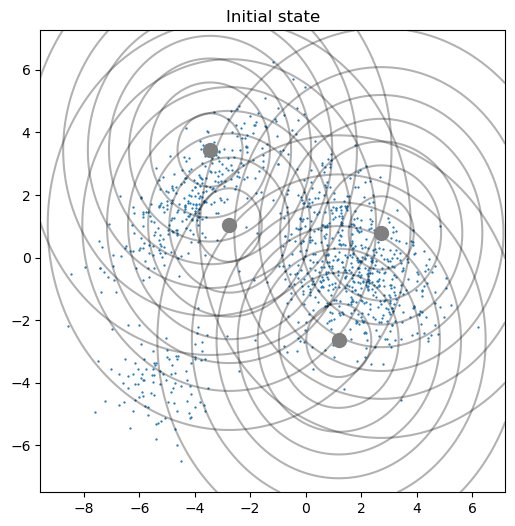

In [120]:



theta = initialisation_theta(X, m = 4)
mus , sigmas, alphas = theta[0].copy(),theta[1].copy(), theta[2].copy()


reg_cov = 1e-6*np.identity(len(X[0]))
x,y = np.meshgrid( np.linspace(np.min(X[:,0]) - 1, np.max(X[:,0]) +1 ,num = 100),np.linspace(np.min(X[:,1]) - 1, np.max(X[:,1]) +1, num = 100))

XY = np.array([x.flatten(),y.flatten()]).T


fig = plt.figure(figsize=(6,6))
ax0 = fig.add_subplot(111)
ax0.scatter(X[:,0],X[:,1], s = 0.4)
ax0.set_title('Initial state')
for m,c in zip(mus,sigmas):
    c += reg_cov
    multi_normal = multivariate_normal(mean=m,cov=c)
    ax0.contour(x,y,multi_normal.pdf(XY).reshape(len(x),len(x)),colors='black',alpha=0.3)
    ax0.scatter(m[0],m[1],c='grey',zorder=10,s=100)
plt.show()

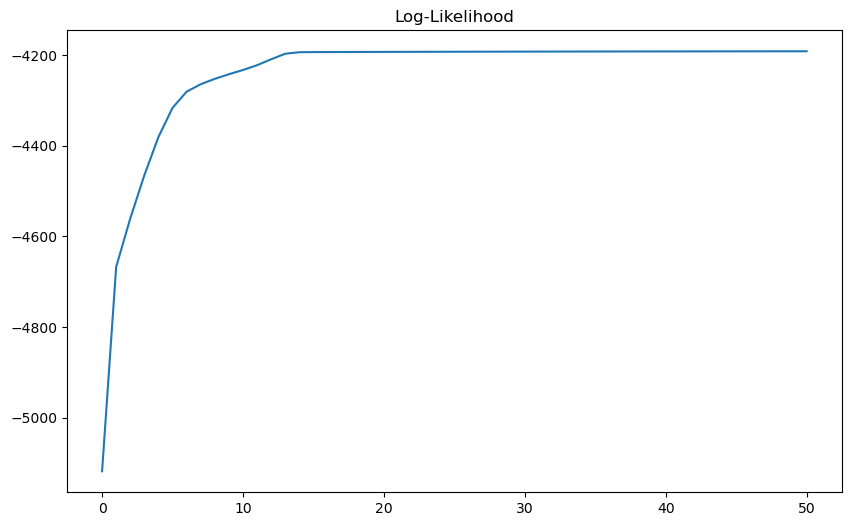

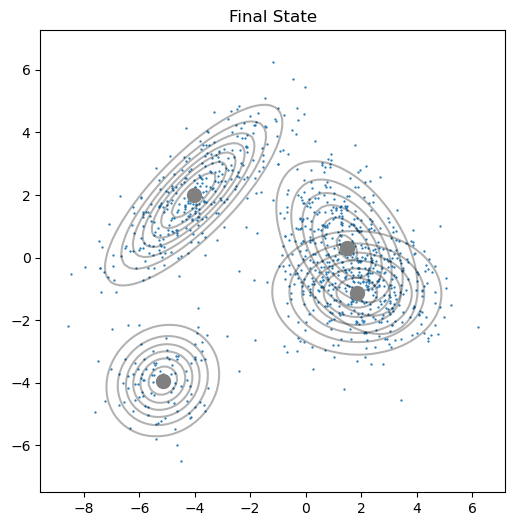

In [121]:


log_likelihoods = [log_likelihood(theta,X)]
num_iterations = 50
for j in range(num_iterations) :
    taux = expectation(theta,X)
    theta = maximization(taux,X)
    log_likelihoods.append(log_likelihood(theta,X))

    
mus , sigmas, alphas = theta[0].copy(),theta[1].copy(), theta[2].copy()

fig1 = plt.figure(figsize=(10,6))
ax1 = fig1.add_subplot(111) 
ax1.set_title('Log-Likelihood')
ax1.plot(range(num_iterations + 1),log_likelihoods)

fig = plt.figure(figsize=(6,6))
ax0 = fig.add_subplot(111)
ax0.scatter(X[:,0],X[:,1], s = 0.4)
ax0.set_title('Final State')
for m,c in zip(mus,sigmas):
    c += reg_cov
    multi_normal = multivariate_normal(mean=m,cov=c)
    ax0.contour(x,y,multi_normal.pdf(XY).reshape(len(x),len(x)),colors='black',alpha=0.3)
    ax0.scatter(m[0],m[1],c='grey',zorder=10,s=100)
plt.show()

## 4.

The estimated parametres are close to the original ones

## 5.

In [122]:
import pandas as pd

In [123]:
df = pd.read_csv('Crude-BirthDeath-Rate.csv').replace([np.inf, -np.inf], np.nan).dropna()
df = np.array(df)

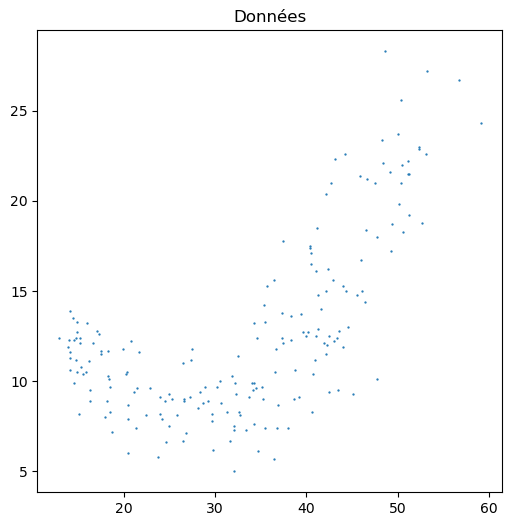

In [124]:
fig = plt.figure(figsize=(6,6))
ax0 = fig.add_subplot(111)
ax0.scatter(df[:,0],df[:,1], s = 0.4)
ax0.set_title('Données')
plt.show()

using a gaussian mixture to modelize these points seems reasonable. It visually looks like the points are distributed in three gaussian-like ellipsoids

In [125]:
def BIC_2d(theta,X) :
    K = theta[0].shape[0]
    return(- log_likelihood(theta,X) + (K*6 - 1)*np.log(X.shape[0])/2.0)

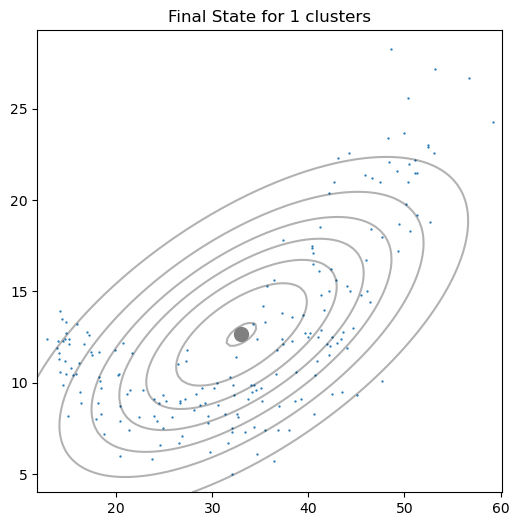

 le BIC pour 1 clusters est 1302.5180035292753


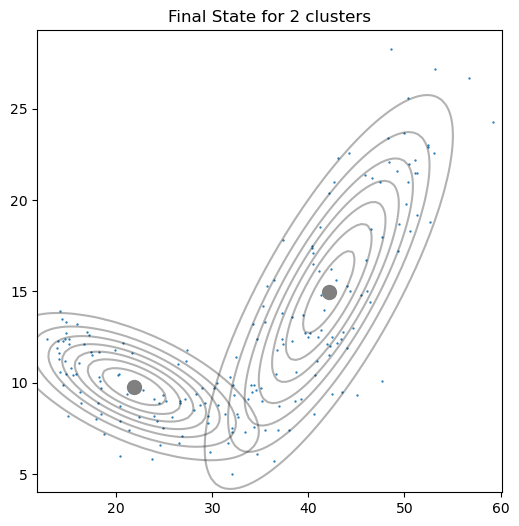

 le BIC pour 2 clusters est 1215.450658067098


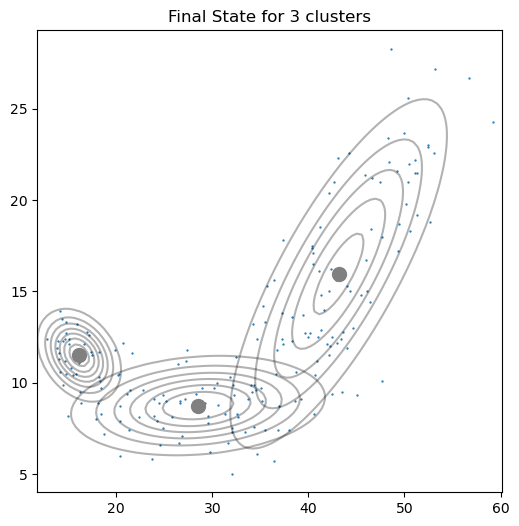

 le BIC pour 3 clusters est 1208.0840071560783


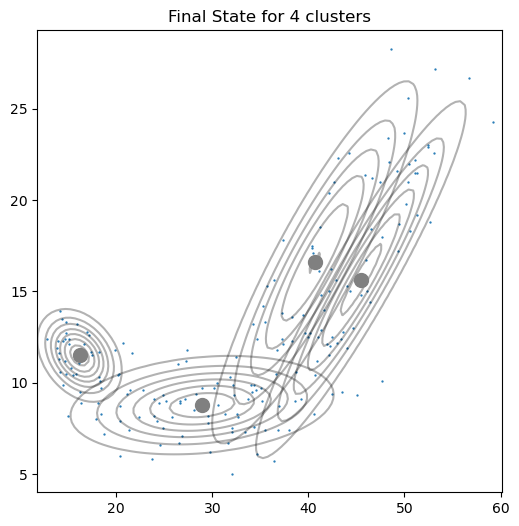

 le BIC pour 4 clusters est 1219.9878325416312


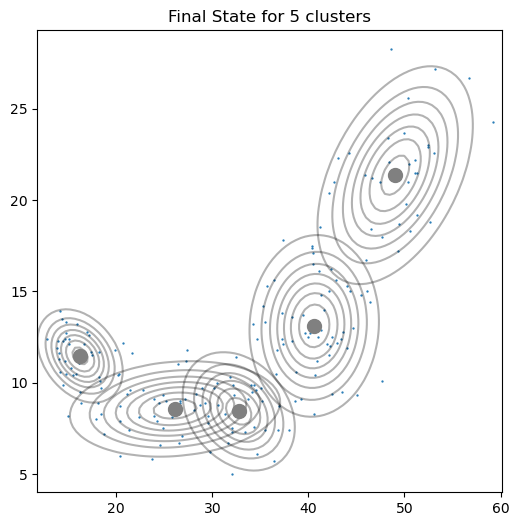

 le BIC pour 5 clusters est 1230.5514364733488


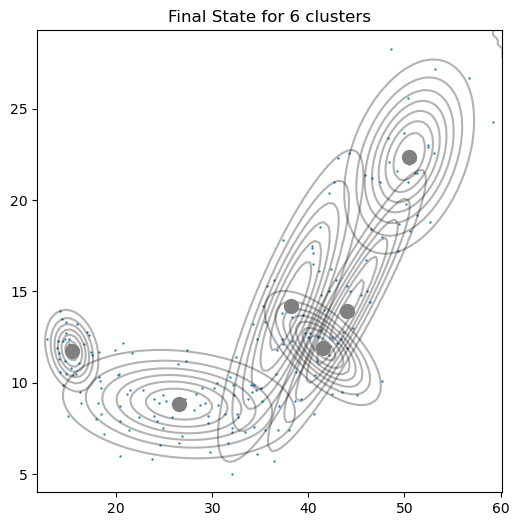

 le BIC pour 6 clusters est 1241.1069101352248


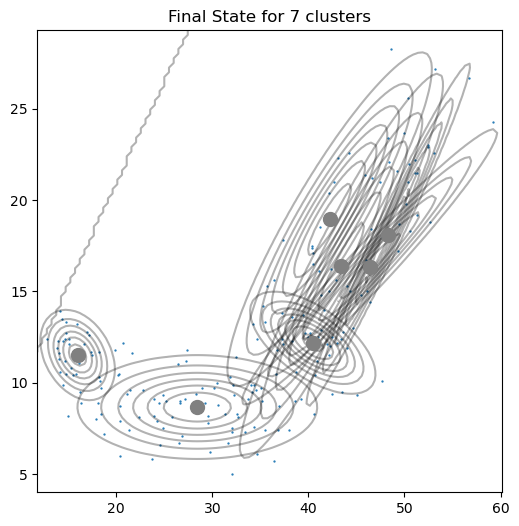

 le BIC pour 7 clusters est 1257.1219124423667


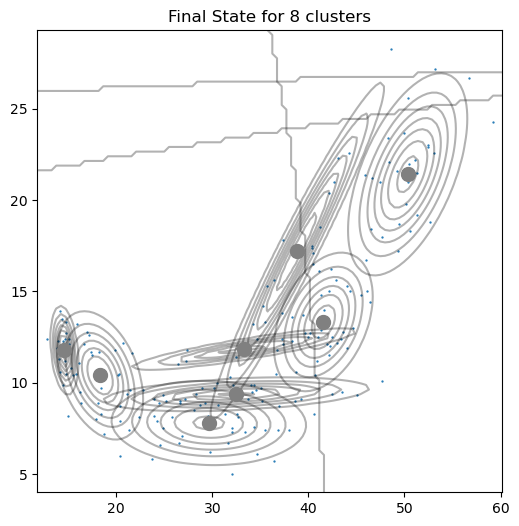

 le BIC pour 8 clusters est 1259.8186752310412


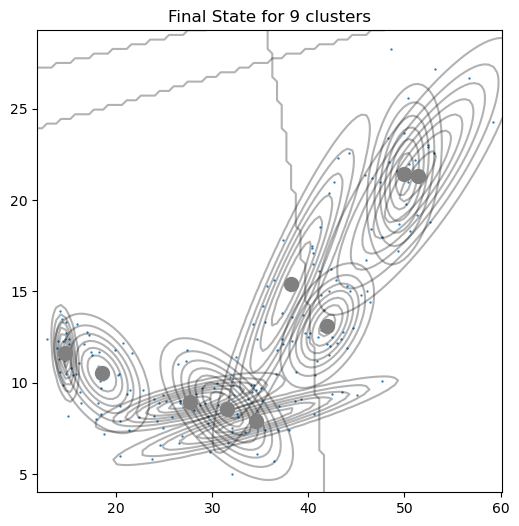

 le BIC pour 9 clusters est 1274.1640093548012


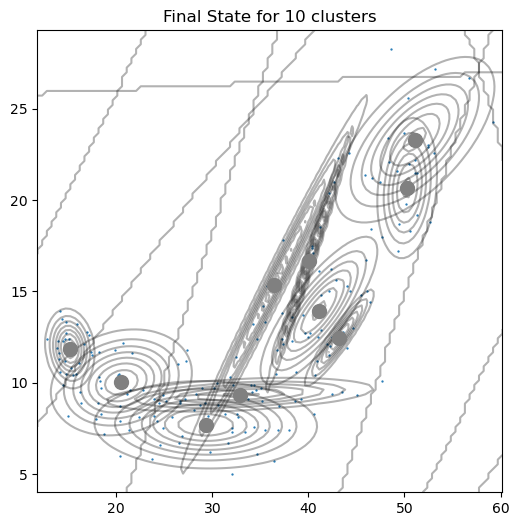

 le BIC pour 10 clusters est 1281.9158326249114


In [126]:
X = np.array(df)
BIC_list = []
for num_clusters in range(1,11) :
    theta = initialisation_theta(df, num_clusters)
    mus,sigmas,alphas = theta

    num_iterations = 100
    for j in range(num_iterations) :
        taux = expectation(theta,df)
        theta = maximization(taux,df)
    mus,sigmas,alphas = theta
    reg_cov = 1e-6*np.identity(len(X[0]))
    x,y = np.meshgrid( np.linspace(np.min(X[:,0]) - 1, np.max(X[:,0]) +1 ,num = 100),np.linspace(np.min(X[:,1]) - 1, np.max(X[:,1]) +1, num = 100))
    XY = np.array([x.flatten(),y.flatten()]).T
        
    fig = plt.figure(figsize=(6,6))
    ax0 = fig.add_subplot(111)
    ax0.scatter(df[:,0],df[:,1], s = 0.4)
    ax0.set_title('Final State for ' + str(num_clusters) + " clusters")
    for m,c in zip(mus,sigmas):
        c += reg_cov
        multi_normal = multivariate_normal(mean=m,cov=c)
        ax0.contour(x,y,multi_normal.pdf(XY).reshape(len(x),len(x)),colors='black',alpha=0.3)
        ax0.scatter(m[0],m[1],c='grey',zorder=10,s=100)
    plt.show()
    
    print(" le BIC pour " + str(num_clusters) + " clusters est " + str(BIC_2d(theta,df)))
    BIC_list.append(BIC_2d(theta,df))

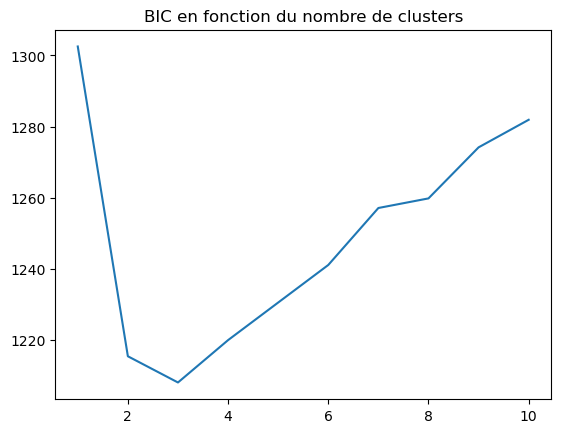

In [127]:
plt.plot(range(1,11),BIC_list)
plt.title("BIC en fonction du nombre de clusters")
plt.show()

# Exercice 3 : importance Sampling

In [128]:
import scipy.integrate as integrate

def p_(x) :
    if x < 0 :
        return(0)
    return(x**(1.65 - 1)*np.exp(-x**2/2))

print("la constante de normalisation de p est ", integrate.quad(p_, 0, float('inf'))[0] )

la constante de normalisation de p est  1.0073680119955206


In [129]:
from scipy.stats import norm

def f(x) :
    R = np.zeros(x.size)
    R[ x < 0] = 0
    R[x>= 0 ] = 2*np.sin( np.pi*x[x>= 0]/1.5)
    return(R)

def p(x) :
    R = np.zeros(x.size)
    R[x>= 0] = x[x>= 0]**(1.65 - 1)*np.exp(-x[x>= 0]**2/2)/1.0073680119955206
    R[x<0] = 0
    return(R)

def q(x, mu = 0.8) :
    return(norm(loc = mu, scale = np.sqrt(1.5)).pdf(x))



In [130]:

def estimate_integral(num_sampling, mu = 0.8) :
    q_sample = norm(loc = mu, scale = np.sqrt(1.5)).rvs(size=num_estimation)
    E = np.mean(p(q_sample)/q(q_sample, mu = mu) * f(q_sample))
    return(E)

## 2.

In [131]:
for num_sampling in [10,100,1000,10000] :
    values = []
    num_estimation = 1000
    for k in range(100) :
        values.append(estimate_integral(num_sampling))
    print("for ", num_sampling, " number of sampling we obtain a variance of ", np.var(values), " with ",num_estimation, " run of the estimation")

for  10  number of sampling we obtain a variance of  0.003043621656340567  with  1000  run of the estimation
for  100  number of sampling we obtain a variance of  0.002825525680406076  with  1000  run of the estimation
for  1000  number of sampling we obtain a variance of  0.0029337734048332583  with  1000  run of the estimation
for  10000  number of sampling we obtain a variance of  0.003008618627927843  with  1000  run of the estimation


In [132]:
print("with the mean of q shifted to 6 : \n")
for num_sampling in [10,100,1000,10000] :
    values = []
    num_estimation = 100000
    for k in range(100) :
        values.append(estimate_integral(num_sampling, mu = 6))
    print("for ", num_sampling, " number of sampling we obtain a variance of ", np.var(values), " with ",num_estimation, " run of the estimation")

with the mean of q shifted to 6 : 

for  10  number of sampling we obtain a variance of  0.36183946627569796  with  100000  run of the estimation
for  100  number of sampling we obtain a variance of  0.40694725939151616  with  100000  run of the estimation
for  1000  number of sampling we obtain a variance of  0.35891332153654804  with  100000  run of the estimation
for  10000  number of sampling we obtain a variance of  0.36179482257565654  with  100000  run of the estimation


On observe que lorsque la densité q est mal choisie le calcul de l'espérence converge beaucoup beaucoup plus lentement

## 5.

In [133]:
d =  5
b = 0.4 

def densite_nu(x) : 
    sigma = np.identity(d)
    mu = 0
    x[1] = x[1] + b*(x[0]**2 - 1)
    return(np.exp( - (x-mu).T@np.linalg.inv(sigma)@(x-mu)/2.0 )/(np.sqrt(np.linalg.det(sigma))*np.sqrt(2*np.pi)**d) )

def densite_q(x,theta) :
    mus,sigmas,alphas = theta
    return np.sum([ alphas[i]*gauss(mus[i],sigmas[i],x) for i in range(len(alphas)) ])

def maximization2(taux,X,omegas) :
    n = taux.shape[0]
    num_gauss = taux.shape[1]
    d = X.shape[1]
    alpha = 1.0/n*np.matmul(omegas,taux)
    mus = np.einsum('ij,i,id->jd',taux,omegas,X)/np.matmul(omegas,taux)[:,None]
    sigma = np.zeros( (num_gauss,d,d))
    for k in range(num_gauss) :
        inter = (X - mus[k,None,:])[:,:,None]
        ACC = np.zeros((d,d))
        for i in range(n) :
            ACC = ACC + omegas[i]*taux[i][k]*(inter[i])@inter[i].T
        sigma[k] = ACC
    sigma = sigma/np.matmul(omegas,taux)[:,None,None]
    return([mus,sigma,alpha] )

def expectation2(theta,X) :
    mus , sigmas, alphas = theta[0].copy(),theta[1].copy(), theta[2].copy()
    d = sigmas.shape[1]
    temp = np.zeros((X.shape[0],mus.shape[0]))
    for j in range(mus.shape[0]) :
        for i in range(X.shape[0]) :
            temp[i][j] = alphas[j]*gauss(mus[j],sigmas[j],X[i])
    temp = temp + 1e-32
    temp2 = np.sum(temp,axis = 1).T
    return(temp/np.expand_dims(temp2,axis = 1 ))

In [134]:

# nombre de cluster : assez grand pour une bonne approximation, pas trop grand pour converger vite.
M = 5

# pour l'initialisation on se resert de la fonction qu'on avait codé dans l'exercice 2 même si on peut faire plus élégant
mus, sigmas, alphas = initialisation_theta(np.random.normal(size = (M,d) ),m = M,d=d)
mus, sigmas, alphas = mus.astype('float64'), sigmas.astype('float64'), alphas.astype('float64')
theta = [ mus, sigmas, alphas ]

eps = 1e-32

for l in range(5) :
    nombre_points_genere = 10000
    list_points = np.zeros((nombre_points_genere,d))
    for i in range(nombre_points_genere) :
        j = loi(range(M),alphas)
        list_points[i] = np.random.multivariate_normal(mean = mus[j], cov = sigmas[j] , tol = 1e-32)
    # expectation maximization :
    omegas = []
    for k in range(nombre_points_genere) :
        omegas.append(densite_nu(list_points[k])/(densite_q(list_points[k],theta)+eps ) )
    omegas = np.array(omegas)/np.sum(omegas)
    
    num_iterations = 15
    for j in range(num_iterations) :
        taux = expectation2(theta,list_points)
        theta = maximization2(taux,list_points,omegas)

        

    

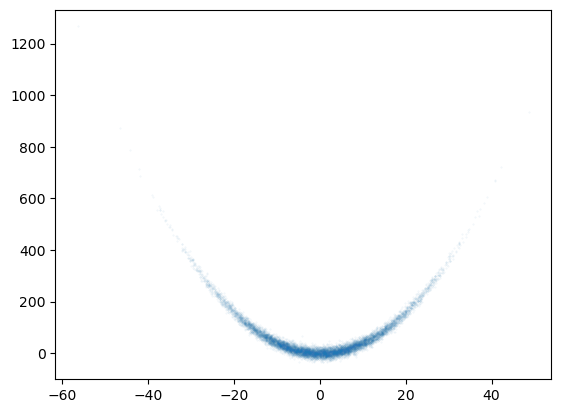

In [135]:
plt.scatter(list_points[:,0],list_points[:,1], s = 0.1, alpha = 0.1)
plt.show()

On voit la densité voulue 